## Imports

In [1]:
%matplotlib inline

import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
plt.style.use('ggplot')

In [3]:
def jitter(values, sd=0.25):
    return [np.random.normal(v, sd) for v in values]

## Data

### Load

In [4]:
df = pd.read_csv('../data/newtrain.csv')

In [5]:
df.head()

,Category,Text
0,5,why are yawns contagious? when people yawn
1,6,what is trans fat? how to reduce that? i heard...
2,1,roth ira vs 401k? what is the difference betwe...
3,1,how many planes fedex has? i heard that it is ...
4,2,what is the best photo slideshow creation appl...


### Clean

Remove non-alpha numeric characters and extra whitespace.

In [6]:
df['text_clean'] = df['Text'].apply(lambda x: re.sub('[^A-Za-z0-9]+', ' ', x.lower()))\
                             .apply(lambda x: re.sub('\s+', ' ', x).strip())

In [7]:
df_ql = df.copy()

In [8]:
df_ql = df_ql[['Category', 'text_clean']]

In [9]:
df_ql['all_questions'] = df_ql.apply(lambda row:
                                     df.groupby('Category').get_group(row['Category'])['text_clean'].tolist(),
                                     axis=1)

In [10]:
df_ql.drop_duplicates(subset='Category', inplace=True)
df_ql.sort(columns='Category', inplace=True)
df_ql.reset_index(drop=True, inplace=True)

In [11]:
df_ql = df_ql[['Category', 'all_questions']]

In [12]:
df_ql.all_questions

0    [roth ira vs 401k what is the difference betwe...
1    [what is the best photo slideshow creation app...
2    [what was the first dvd you ever bought what w...
3    [what is the reason for the increasing divorce...
4    [why are yawns contagious when people yawn, wh...
5    [what is trans fat how to reduce that i heard ...
6    [what is an imaginary number what is an imagin...
Name: all_questions, dtype: object

In [13]:
documents = []

for i in range(len(df_ql)):
    documents.append(' '.join(df_ql['all_questions'][i]))

### tfidf

In [14]:
tfidf = TfidfVectorizer(stop_words='english')

In [15]:
category_matrix = tfidf.fit_transform(documents)

In [16]:
category_matrix.shape

(7, 6170)

In [17]:
question_matrix = tfidf.fit_transform(df.text_clean.values)

In [18]:
question_matrix.shape

(2698, 6170)

In [19]:
cos_scores = cosine_similarity(question_matrix, category_matrix)

In [20]:
df['cosine_similarity'] = np.argmax(cos_scores, axis=1) + 1

In [21]:
df.head()

,Category,Text,text_clean,cosine_similarity
0,5,why are yawns contagious? when people yawn,why are yawns contagious when people yawn,5
1,6,what is trans fat? how to reduce that? i heard...,what is trans fat how to reduce that i heard t...,6
2,1,roth ira vs 401k? what is the difference betwe...,roth ira vs 401k what is the difference betwee...,1
3,1,how many planes fedex has? i heard that it is ...,how many planes fedex has i heard that it is t...,5
4,2,what is the best photo slideshow creation appl...,what is the best photo slideshow creation appl...,2


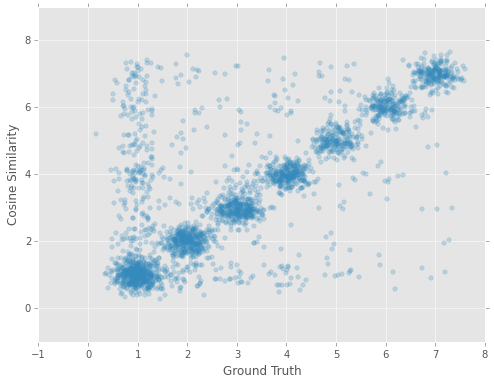

In [22]:
plt.figure(figsize=(8, 6))

plt.scatter(jitter(df.Category),
            jitter(df.cosine_similarity),
            color='#348ABD', alpha=0.25)

plt.xlabel('Ground Truth')
plt.ylabel('Cosine Similarity')

In [23]:
sum(df.Category == df.cosine_similarity) / len(df)

0.81578947368421051